# Search: Solving a Maze Using a Goal-based Agent

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file. 


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent 
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.** 
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state. 
* **Discrete** means that we have a **finite set of states.** The maze has a finite set 
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The 
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [2]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

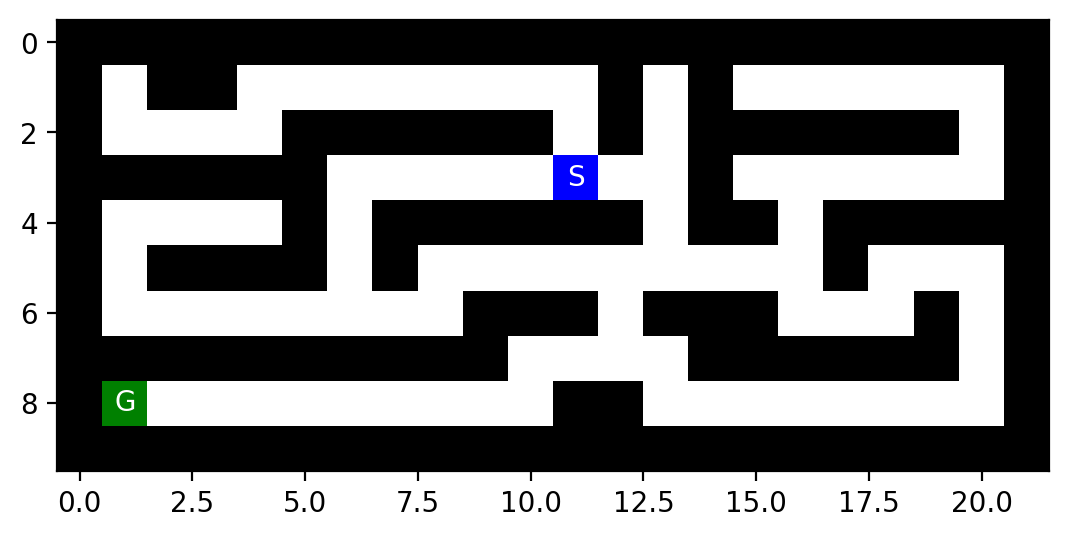

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [5]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.
    
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.
    
 

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

In [7]:
# Your answer goes here
# ===== Task 1: Define the search problem for Maze =====
from collections import namedtuple
import maze_helper as mh

# Action định nghĩa gọn
Action = namedtuple("Action", ["name", "dr", "dc"])
ACTIONS = [
    Action("UP",    -1,  0),
    Action("DOWN",   1,  0),
    Action("LEFT",   0, -1),
    Action("RIGHT",  0,  1),
]

class MazeProblem:
    """
    Mô hình hoá bài toán mê cung theo khuôn 'search problem':
      - state: (r, c)
      - initial_state: vị trí 'S'
      - goal_test(s): s == vị trí 'G'
      - successors(s): list[(s_next, action, step_cost=1)]
      - step_cost(s, a, s'): 1
    """
    def __init__(self, maze):
        """
        maze: cấu trúc 2D (list[list[str]] hoặc np.ndarray) sau khi parse bằng mh.parse_maze
        """
        self.maze = maze
        self.start = mh.find_pos(maze, "S")
        self.goal  = mh.find_pos(maze, "G")
        if self.start is None or self.goal is None:
            raise ValueError("Thiếu S hoặc G trong mê cung.")
        
        # tiền xử lý kích thước
        self.n_rows = len(maze)
        self.n_cols = len(maze[0]) if self.n_rows > 0 else 0

    def initial_state(self):
        return self.start

    def goal_test(self, s):
        return s == self.goal

    def in_bounds(self, r, c):
        return 0 <= r < self.n_rows and 0 <= c < self.n_cols

    def passable(self, r, c):
        cell = mh.look(self.maze, (r, c))
        # Quy ước: tường 'X'; còn lại đi được (bao gồm 'S', 'G', ' ')
        return cell != 'X'

    def successors(self, s): # tính được toàn bộ trường hợp kế tiếp
        r, c = s
        out = []
        for a in ACTIONS:
            nr, nc = r + a.dr, c + a.dc
            if self.in_bounds(nr, nc) and self.passable(nr, nc):
                out.append(((nr, nc), a.name, 1))  # (state', action, cost=1)
        return out

    def step_cost(self, s, a, s_prime):
        return 1

# ===== Sanity check nhanh cho Task 1 =====
# Ví dụ load một maze từ chuỗi (hoặc từ file text, tuỳ notebook đã hướng dẫn)
sample_maze_str = """
#########
#S  #   #
# # # # #
# #   #G#
# ##### #
#       #
#########
""".strip("\n")

maze = mh.parse_maze(sample_maze_str)
problem = MazeProblem(maze)

print("Start:", problem.initial_state())
print("Goal :", problem.goal)
s0 = problem.initial_state()
print("Successors of start:")
for ns, act, cost in problem.successors(s0):
    print("  ->", ns, act, cost)

Start: (np.int64(1), np.int64(1))
Goal : (np.int64(3), np.int64(7))
Successors of start:
  -> (np.int64(0), np.int64(1)) UP 1
  -> (np.int64(2), np.int64(1)) DOWN 1
  -> (np.int64(1), np.int64(0)) LEFT 1
  -> (np.int64(1), np.int64(2)) RIGHT 1


Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [8]:
"""
Ước lượng kích thước bài toán tìm đường trong mê cung:

- n (state space size): 
  Mỗi state là một ô (r, c) có thể đi được trong mê cung.
  Do đó, n ≈ số ô không phải tường(bao gồm cả vị trí S và G). 
  Ví dụ, mê cung 10x10 có 70 ô trống → n ≈ 70.

- d (depth of the optimal solution): 
  Là độ dài đường đi ngắn nhất từ S đến G.
  Với chi phí mỗi bước = 1, d = số bước trong đường đi tối ưu.
  Có thể tìm chính xác bằng BFS, hoặc ước lượng bằng Manhattan distance giữa S và G.

- m (maximum depth of the tree): 
  Là độ sâu lớn nhất mà thuật toán có thể mở rộng.
  Trong trường hợp xấu nhất, phải thăm toàn bộ các ô → m ≈ n.

- b (maximum branching factor):
  Là số hành động tối đa có thể từ một state.
  Với mê cung 4 hướng di chuyển (lên, xuống, trái, phải), b = 4.

Tóm lại, với mê cung kích thước R x C:
  n ≤ R*C
  b = 4
  d phụ thuộc vị trí S và G (có thể tính bằng BFS)
  m ≤ n
"""

'\nƯớc lượng kích thước bài toán tìm đường trong mê cung:\n\n- n (state space size): \n  Mỗi state là một ô (r, c) có thể đi được trong mê cung.\n  Do đó, n ≈ số ô không phải tường(bao gồm cả vị trí S và G). \n  Ví dụ, mê cung 10x10 có 70 ô trống → n ≈ 70.\n\n- d (depth of the optimal solution): \n  Là độ dài đường đi ngắn nhất từ S đến G.\n  Với chi phí mỗi bước = 1, d = số bước trong đường đi tối ưu.\n  Có thể tìm chính xác bằng BFS, hoặc ước lượng bằng Manhattan distance giữa S và G.\n\n- m (maximum depth of the tree): \n  Là độ sâu lớn nhất mà thuật toán có thể mở rộng.\n  Trong trường hợp xấu nhất, phải thăm toàn bộ các ô → m ≈ n.\n\n- b (maximum branching factor):\n  Là số hành động tối đa có thể từ một state.\n  Với mê cung 4 hướng di chuyển (lên, xuống, trái, phải), b = 4.\n\nTóm lại, với mê cung kích thước R x C:\n  n ≤ R*C\n  b = 4\n  d phụ thuộc vị trí S và G (có thể tính bằng BFS)\n  m ≤ n\n'

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking. 
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [9]:
import maze_helper as mh
from collections import deque
import copy

class Node:
    def __init__(self, state, parent=None, action=None, depth=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.depth = depth

    def path(self):
        cur, out = self, []
        while cur is not None:
            out.append(cur.state)
            cur = cur.parent
        return list(reversed(out))

    def actions(self):
        cur, out = self, []
        while cur is not None and cur.action is not None:
            out.append(cur.action)
            cur = cur.parent
        return list(reversed(out))
    
def snapshot(maze, reached=None, frontier=None, path=None):
    m = copy.deepcopy(maze)
    if reached:
        for r,c in reached:
            if mh.look(m,(r,c)) not in ['S','G']:
                m[r,c] = '.'
    if frontier:
        for r,c in frontier:
            if mh.look(m,(r,c)) not in ['S','G']:
                m[r,c] = 'F'
    if path:
        for r,c in path:
            if mh.look(m,(r,c)) not in ['S','G']:
                m[r,c] = 'P'
    return m

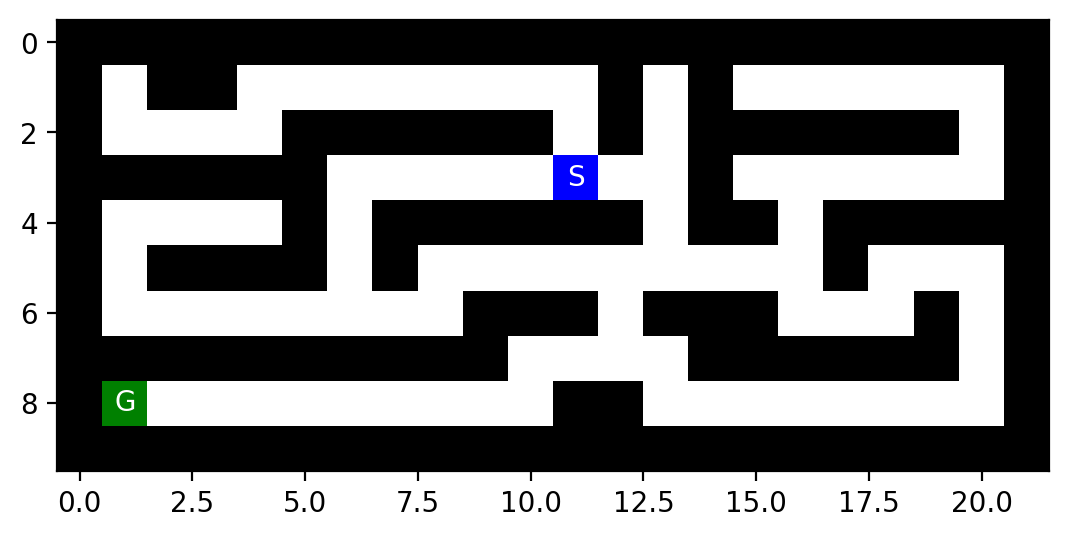

In [10]:
# Load maze
with open("small_maze.txt","r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
mh.show_maze(maze)

problem = MazeProblem(maze)

In [11]:
def bfs_search(problem, animate=False):
    s0 = problem.initial_state()
    if problem.goal_test(s0):
        return {"path":[s0], "reached":{s0}, "actions":[], "maze_anim":[]}

    frontier = deque([Node(s0)]) # khởi tạo ban đầu
    reached  = {s0}
    maze_anim = [snapshot(problem.maze, reached=reached, frontier=[s0])] if animate else []

    nodes_expanded = 0
    max_frontier = 1

    while frontier:
        node = frontier.popleft()
        nodes_expanded += 1

        for s2, a, _ in problem.successors(node.state):
            if s2 in reached:
                continue
            child = Node(s2, parent=node, action=a, depth=node.depth+1)
            if problem.goal_test(s2):
                p = child.path()
                res = {
                    "path": p,
                    "reached": reached | {s2},
                    "actions": child.actions(),
                    "maze_anim": maze_anim + ([snapshot(problem.maze, path=p)] if animate else []),
                    "metrics": {
                        "algo": "BFS",
                        "path_len": len(p)-1,
                        "nodes_expanded": nodes_expanded,
                        "max_frontier": max(max_frontier, len(frontier)+1),
                        "solution_depth": child.depth
                    }
                }
                return res
            reached.add(s2)
            frontier.append(child)

        max_frontier = max(max_frontier, len(frontier))
        if animate:
            maze_anim.append(snapshot(problem.maze, reached=reached, frontier=[n.state for n in frontier]))

    return {"path": None, "reached": reached, "actions": [], "maze_anim": maze_anim, "metrics": {"algo":"BFS"}}

In [12]:


problem = MazeProblem(maze)
# BFS
res_bfs = bfs_search(problem, animate=True)
print(res_bfs["metrics"])
ani_bfs = mh.animate_maze(res_bfs, repeat=False)
from IPython.display import HTML
HTML(ani_bfs.to_jshtml())

{'algo': 'BFS', 'path_len': 19, 'nodes_expanded': 90, 'max_frontier': 8, 'solution_depth': 19}
Path length: 19
Reached squares: 92
Action sequence: ['RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT']


In [13]:
def dfs_search(problem, animate=False):
    s0 = problem.initial_state()
    maze_anim = []
    nodes_expanded = 0
    max_depth_seen = 0
    visited_counter = set()   # <— thêm dòng này

    def rec(node, on_path):
        nonlocal nodes_expanded, max_depth_seen
        nodes_expanded += 1
        max_depth_seen = max(max_depth_seen, node.depth)
        visited_counter.add(node.state)   # <— log state đã ghé

        if problem.goal_test(node.state):
            return node

        for s2, a, _ in problem.successors(node.state):
            if s2 in on_path:    # cycle checking
                continue
            child = Node(s2, parent=node, action=a, depth=node.depth+1)
            on_path.add(s2)
            if animate:
                maze_anim.append(snapshot(problem.maze, path=child.path()))
            res = rec(child, on_path)
            if res is not None:
                return res
            on_path.remove(s2)   # backtrack
        return None

    root = Node(s0)
    sol = rec(root, on_path={s0})
    if sol is None:
        return {
            "path": None,
            "reached": visited_counter,     # <— luôn là set, không None
            "actions": [],
            "maze_anim": maze_anim,
            "metrics": {"algo":"DFS", "nodes_expanded": nodes_expanded, "max_depth_seen": max_depth_seen}
        }
    p = sol.path()
    return {
        "path": p,
        "reached": visited_counter,         # <— luôn là set
        "actions": sol.actions(),
        "maze_anim": maze_anim + ([snapshot(problem.maze, path=p)] if animate else []),
        "metrics": {
            "algo": "DFS",
            "path_len": len(p)-1,
            "solution_depth": len(p)-1,
            "nodes_expanded": nodes_expanded,
            "max_depth_seen": max_depth_seen
        }
    }

# DFS
res_dfs = dfs_search(problem, animate=True)
print(res_dfs["metrics"])
# ani_dfs = mh.animate_maze(res_dfs, repeat=False)
# HTML(ani_dfs.to_html5_video())
ani_dfs = mh.animate_maze(res_dfs, repeat=False)
from IPython.display import HTML
HTML(ani_dfs.to_jshtml())

{'algo': 'DFS', 'path_len': 29, 'solution_depth': 29, 'nodes_expanded': 54, 'max_depth_seen': 29}
Path length: 29
Reached squares: 54
Action sequence: ['LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT']


How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

In [14]:
'''Nếu BFS không có cấu trúc dữ liệu reached hoặc visited nó sẽ không biết là đã đi qua vị trí đó chưa nên sẽ bị lặp vô hạn. 
Còn DFS sẽ không nhớ đường đi nó đã đi qua nên cũng sẽ bị lặp vô hạn nếu không kiểm tra chu kỳ.'''

'Nếu BFS không có cấu trúc dữ liệu reached hoặc visited nó sẽ không biết là đã đi qua vị trí đó chưa nên sẽ bị lặp vô hạn. \nCòn DFS sẽ không nhớ đường đi nó đã đi qua nên cũng sẽ bị lặp vô hạn nếu không kiểm tra chu kỳ.'

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [15]:
# Discussion
"""
- BFS: Hoàn chỉnh, Tối ưu (nếu cost=1); 
  Time = O(b^d), Space = O(b^d)
- **DFS**: Hoàn chỉnh (nếu không kiểm tra chu kỳ), Tối ưu ; 
  Time = O(b^m), Space = O(m)

→ BFS tìm đường ngắn nhất nhưng tốn bộ nhớ; DFS tiết kiệm bộ nhớ hơn nhiều nhưng có thể không dừng hoặc không tối ưu.
"""

'\n- BFS: Hoàn chỉnh, Tối ưu (nếu cost=1); \n  Time = O(b^d), Space = O(b^d)\n- **DFS**: Hoàn chỉnh (nếu không kiểm tra chu kỳ), Tối ưu ; \n  Time = O(b^m), Space = O(m)\n\n→ BFS tìm đường ngắn nhất nhưng tốn bộ nhớ; DFS tiết kiệm bộ nhớ hơn nhiều nhưng có thể không dừng hoặc không tối ưu.\n'

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

In [16]:
import heapq, itertools
import maze_helper as mh

counter = itertools.count()  # tie-breaker để heap ổn định

def h_manhattan(problem, s):
    gr, gc = problem.goal
    r, c = s
    return abs(r-gr) + abs(c-gc)


In [17]:
def gbfs_search(problem, animate=False):
    s0 = problem.initial_state()
    if problem.goal_test(s0):
        return {"path":[s0], "reached":{s0}, "actions":[], "maze_anim":[], 
                "metrics":{"algo":"GBFS","path_len":0,"nodes_expanded":0}}

    frontier = []  # (priority, tie, Node)
    heapq.heappush(frontier, (h_manhattan(problem, s0), next(counter), Node(s0)))
    reached = {s0}
    maze_anim = [snapshot(problem.maze, reached=reached, frontier=[s0])] if animate else []

    nodes_expanded, max_frontier = 0, 1

    while frontier:
        _, _, node = heapq.heappop(frontier)
        nodes_expanded += 1

        for s2, a, _ in problem.successors(node.state):
            if s2 in reached:
                continue
            child = Node(s2, parent=node, action=a, depth=node.depth+1)
            if problem.goal_test(s2):
                p = child.path()
                if animate: maze_anim.append(snapshot(problem.maze, path=p))
                return {
                    "path": p,
                    "reached": reached | {s2},
                    "actions": child.actions(),
                    "maze_anim": maze_anim if animate else [],
                    "metrics": {
                        "algo":"GBFS",
                        "path_len": len(p)-1,
                        "nodes_expanded": nodes_expanded,
                        "max_frontier": max(max_frontier, len(frontier)+1),
                        "solution_depth": child.depth
                    }
                }
            reached.add(s2)
            heapq.heappush(frontier, (h_manhattan(problem, s2), next(counter), child))

        max_frontier = max(max_frontier, len(frontier))
        if animate:
            maze_anim.append(snapshot(problem.maze, reached=reached, frontier=[n[2].state for n in frontier]))

    return {"path": None, "reached": reached, "actions": [], "maze_anim": maze_anim, 
            "metrics":{"algo":"GBFS","nodes_expanded":nodes_expanded}}


In [18]:
import heapq, itertools
counter = itertools.count()

def h_manhattan(problem, s):
    (r, c) = s
    (gr, gc) = problem.goal
    return abs(r - gr) + abs(c - gc)

def astar_search(problem, animate=False):
    s0 = problem.initial_state()
    if problem.goal_test(s0):
        return {"path":[s0], "reached":{s0}, "actions":[], "maze_anim":[],
                "metrics":{"algo":"A*", "path_len":0, "nodes_expanded":0}}

    # Khởi tạo
    g_cost = {s0: 0}
    frontier = []
    heapq.heappush(frontier, (h_manhattan(problem, s0), next(counter), Node(s0)))
    maze_anim = [snapshot(problem.maze, reached={s0}, frontier=[s0])] if animate else []

    nodes_expanded, max_frontier = 0, 1

    while frontier:
        f, _, node = heapq.heappop(frontier)
        s = node.state
        nodes_expanded += 1

        # Nếu đạt goal → dừng
        if problem.goal_test(s):
            p = node.path()
            if animate: maze_anim.append(snapshot(problem.maze, path=p))
            return {
                "path": p,
                "reached": set(g_cost.keys()),
                "actions": node.actions(),
                "maze_anim": maze_anim,
                "metrics": {
                    "algo": "A*",
                    "path_len": len(p) - 1,
                    "nodes_expanded": nodes_expanded,
                    "solution_depth": node.depth,
                    "max_frontier": max_frontier
                }
            }

        # Mở rộng neighbor
        for s2, a, step in problem.successors(s):
            new_g = g_cost[s] + step
            if s2 not in g_cost or new_g < g_cost[s2]:
                g_cost[s2] = new_g
                f2 = new_g + h_manhattan(problem, s2)
                child = Node(s2, parent=node, action=a, depth=node.depth+1)
                heapq.heappush(frontier, (f2, next(counter), child))
        max_frontier = max(max_frontier, len(frontier))
        if animate:
            maze_anim.append(snapshot(problem.maze, reached=set(g_cost.keys()),
                                      frontier=[n[2].state for n in frontier]))

    return {"path": None, "reached": set(g_cost.keys()), "actions": [], "maze_anim": maze_anim,
            "metrics": {"algo": "A*", "nodes_expanded": nodes_expanded}}


In [19]:
# Đảm bảo passable() đang chặn 'X'
# def passable(self, r, c): return mh.look(self.maze,(r,c)) in {' ','S','G'}

with open("small_maze.txt","r") as f:
    maze = mh.parse_maze(f.read())
problem = MazeProblem(maze)

# GBFS
res_gbfs = gbfs_search(problem, animate=True)
print(res_gbfs["metrics"])
from IPython.display import HTML
HTML(mh.animate_maze(res_gbfs, repeat=False).to_jshtml())

{'algo': 'GBFS', 'path_len': 29, 'nodes_expanded': 39, 'max_frontier': 5, 'solution_depth': 29}
Path length: 29
Reached squares: 44
Action sequence: ['LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT']


In [20]:
# A*
res_astar = astar_search(problem, animate=True)
print(res_astar["metrics"])
HTML(mh.animate_maze(res_astar, repeat=False).to_jshtml())

{'algo': 'A*', 'path_len': 19, 'nodes_expanded': 54, 'solution_depth': 19, 'max_frontier': 8}
Path length: 19
Reached squares: 59
Action sequence: ['RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT']


Are your implementations complete and optimal? What is the time and space complexity?

In [21]:
# Discussion
"""
Heuristic dùng: Manhattan distance (admissible & consistent) cho lưới 4 hướng.

- GBFS: ưu tiên h(s) nhỏ nhất → nhanh trong mê cung “thẳng hướng goal” nhưng có thể lạc lối,
  không đảm bảo tối ưu. Time gần O(b^d) (phụ thuộc h), Space phụ thuộc frontier (có thể lớn).
- A*: f = g + h. Với Manhattan, A* hoàn chỉnh & tối ưu. Time ≈ số node có f <= f* (f* = cost tối ưu),
  Space thường lớn vì phải giữ frontier + g_cost.

Khác biệt: GBFS chỉ nhìn “ước lượng còn lại”, A* cân bằng “đã đi” + “còn lại”, nên đáng tin hơn.
"""


'\nHeuristic dùng: Manhattan distance (admissible & consistent) cho lưới 4 hướng.\n\n- GBFS: ưu tiên h(s) nhỏ nhất → nhanh trong mê cung “thẳng hướng goal” nhưng có thể lạc lối,\n  không đảm bảo tối ưu. Time gần O(b^d) (phụ thuộc h), Space phụ thuộc frontier (có thể lớn).\n- A*: f = g + h. Với Manhattan, A* hoàn chỉnh & tối ưu. Time ≈ số node có f <= f* (f* = cost tối ưu),\n  Space thường lớn vì phải giữ frontier + g_cost.\n\nKhác biệt: GBFS chỉ nhìn “ước lượng còn lại”, A* cân bằng “đã đi” + “còn lại”, nên đáng tin hơn.\n'

## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [22]:
import copy
import pandas as pd
from IPython.display import HTML
import maze_helper as mh

def overlay_and_show(maze, path, title=""):
    m = copy.deepcopy(maze)
    if path:
        for r,c in path:
            if mh.look(m,(r,c)) not in ['S','G']:
                m[r,c] = 'P'
    print(title)
    mh.show_maze(m)

def run_algo(problem, algo_fn, name, animate=False, show_path=False):
    res = algo_fn(problem, animate=animate)
    mets = res.get("metrics", {})
    mets["algo"] = name
    p = res.get("path")
    mets["found"] = p is not None
    if p is not None:
        mets.setdefault("path_len", len(p)-1)
        mets.setdefault("solution_depth", len(p)-1)
    if show_path and p:
        overlay_and_show(problem.maze, p, title=f"{name} path")
    return res, mets


In [23]:
def run_all_on_maze(maze_str, maze_name, animate=False, show_path=False):
    maze = mh.parse_maze(maze_str)
    problem = MazeProblem(maze)
    rows = []
    out = {}

    for fn, name in [(bfs_search,"BFS"), (dfs_search,"DFS"),
                     (gbfs_search,"GBFS"), (astar_search,"A*")]:
        res, m = run_algo(problem, fn, name, animate=animate, show_path=show_path)
        out[name] = res
        m["maze"] = maze_name
        rows.append(m)

    df = pd.DataFrame(rows)
    cols = ["maze","algo","found","path_len","nodes_expanded","solution_depth",
            "max_frontier","max_depth_seen"]
    for c in cols:
        if c not in df.columns: df[c] = None
    df = df[cols]
    return out, df

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)). 

In [24]:
import pandas as pd

def load_txt(path):
    with open(path, "r") as f:
        return f.read()

small = load_txt("small_maze.txt")
medium = load_txt("medium_maze.txt")
large = load_txt("large_maze.txt")

out_s, df_s = run_all_on_maze(small,  "small",  animate=False, show_path=False)
out_m, df_m = run_all_on_maze(medium, "medium", animate=False, show_path=False)
out_l, df_l = run_all_on_maze(large,  "large",  animate=False, show_path=False)

df_all = pd.concat([df_s, df_m, df_l], ignore_index=True)
df_all

maze  algo  found  path_len  nodes_expanded  solution_depth  \
0    small   BFS   True        19              90              19   
1    small   DFS   True        29              54              29   
2    small  GBFS   True        29              39              29   
3    small    A*   True        19              54              19   
4   medium   BFS   True        68             267              68   
5   medium   DFS   True       164             259             164   
6   medium  GBFS   True        74              78              74   
7   medium    A*   True        68             223              68   
8    large   BFS   True       210             617             210   
9    large   DFS   True       210             470             210   
10   large  GBFS   True       210             466             210   
11   large    A*   True       210             550             210   

    max_frontier  max_depth_seen  
0            8.0             NaN  
1            NaN            29.0  
2            5.0             NaN  
3            8.0             NaN  
4            8.0             NaN  
5            NaN           164.0  
6            4.0             NaN  
7            8.0             NaN  
8            8.0             NaN  
9            NaN           210.0  
10          21.0             NaN  
11          12.0             NaN

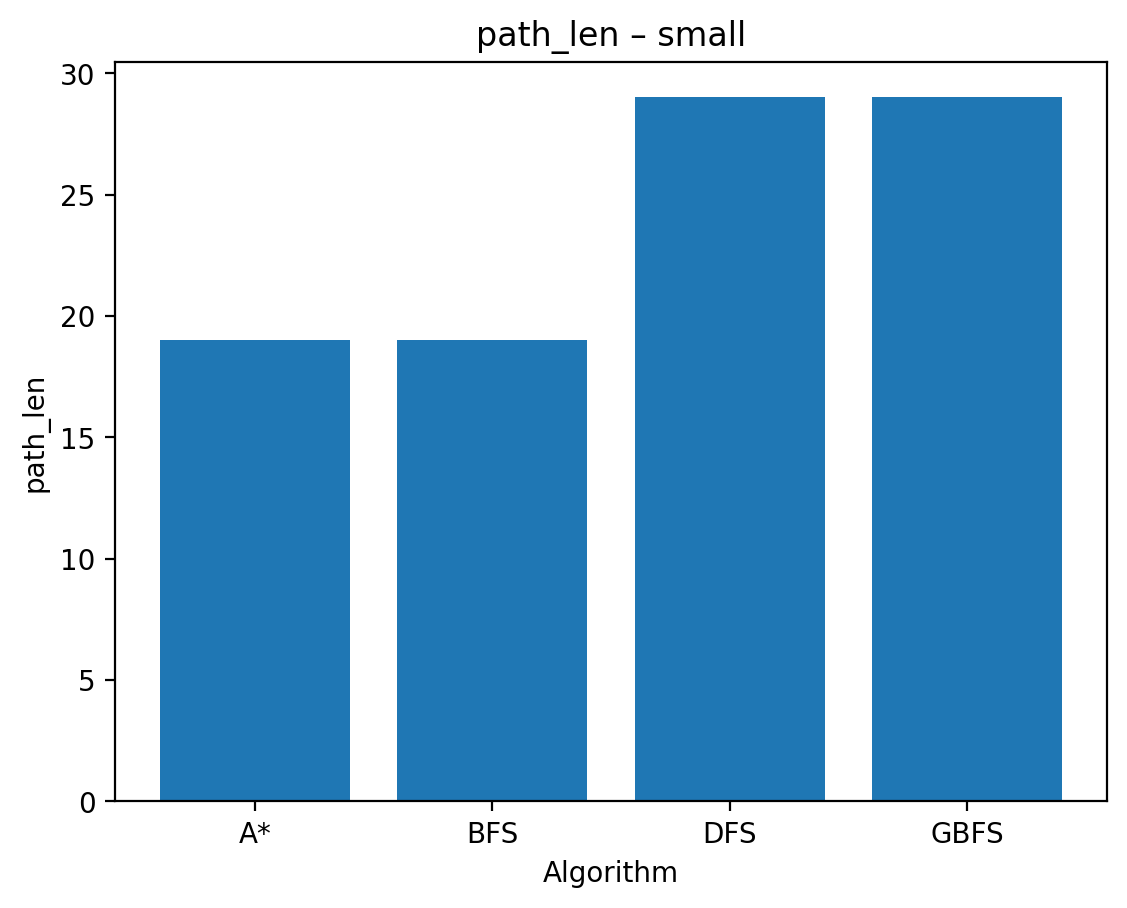

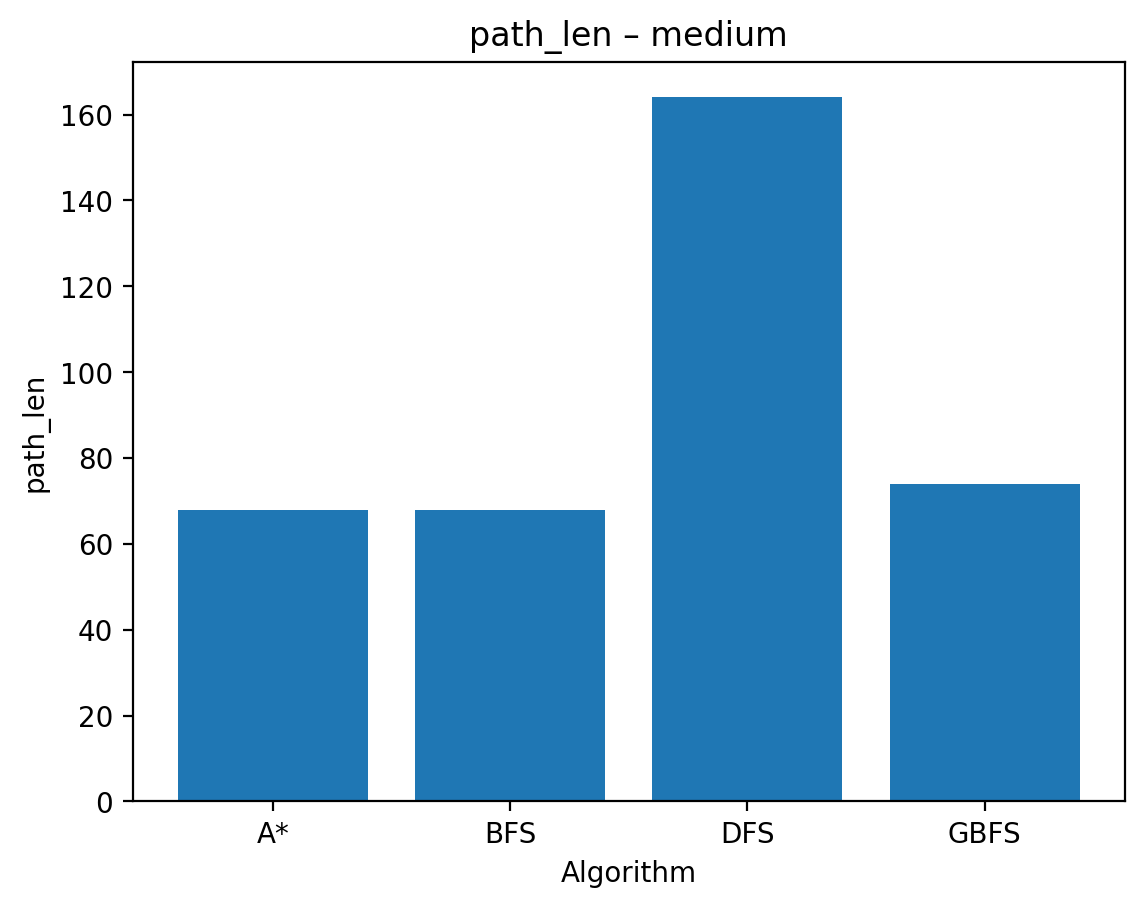

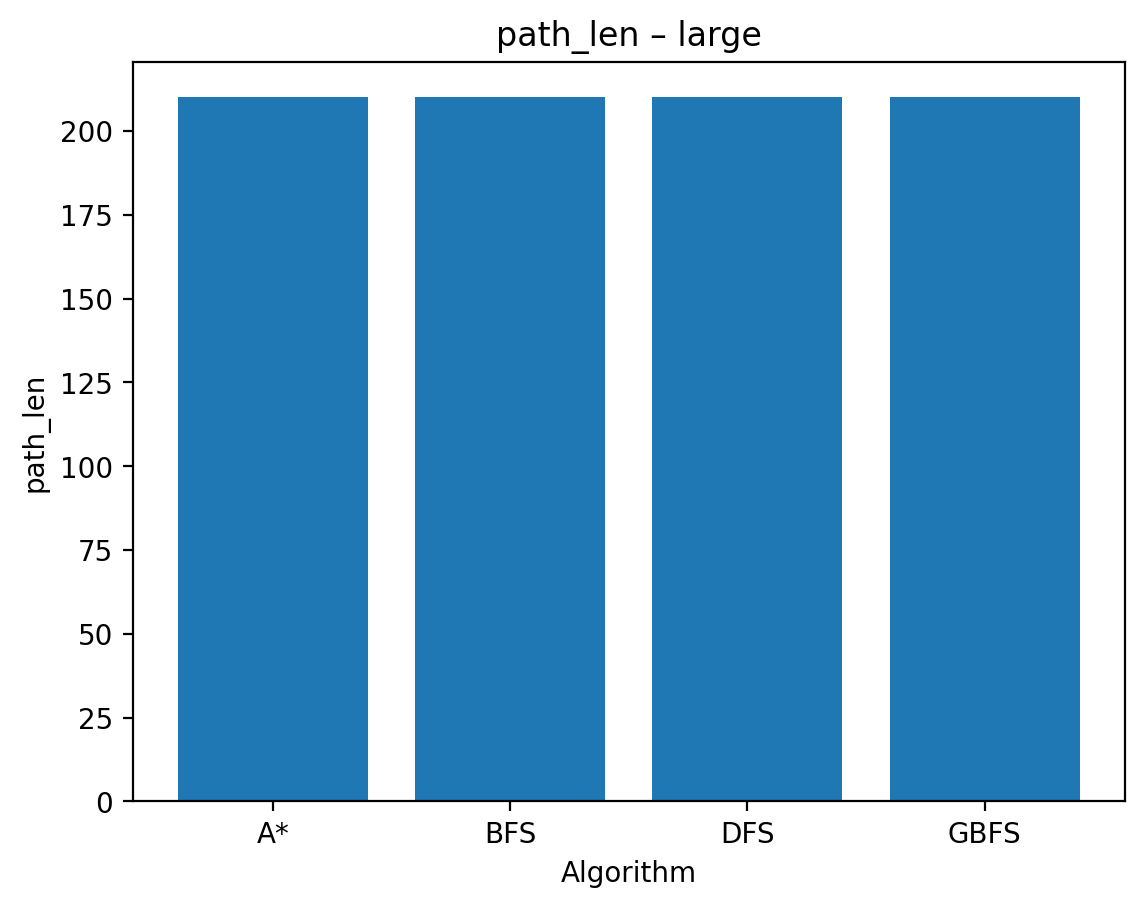

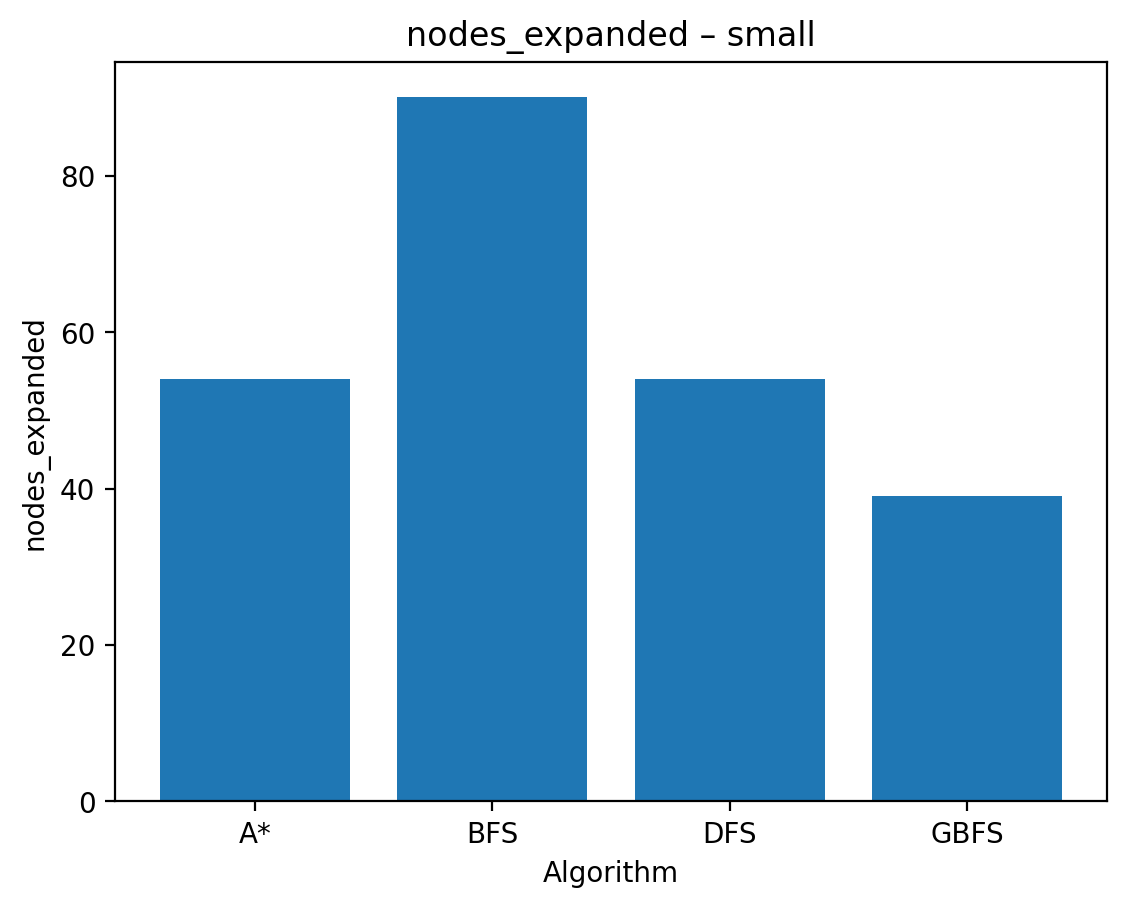

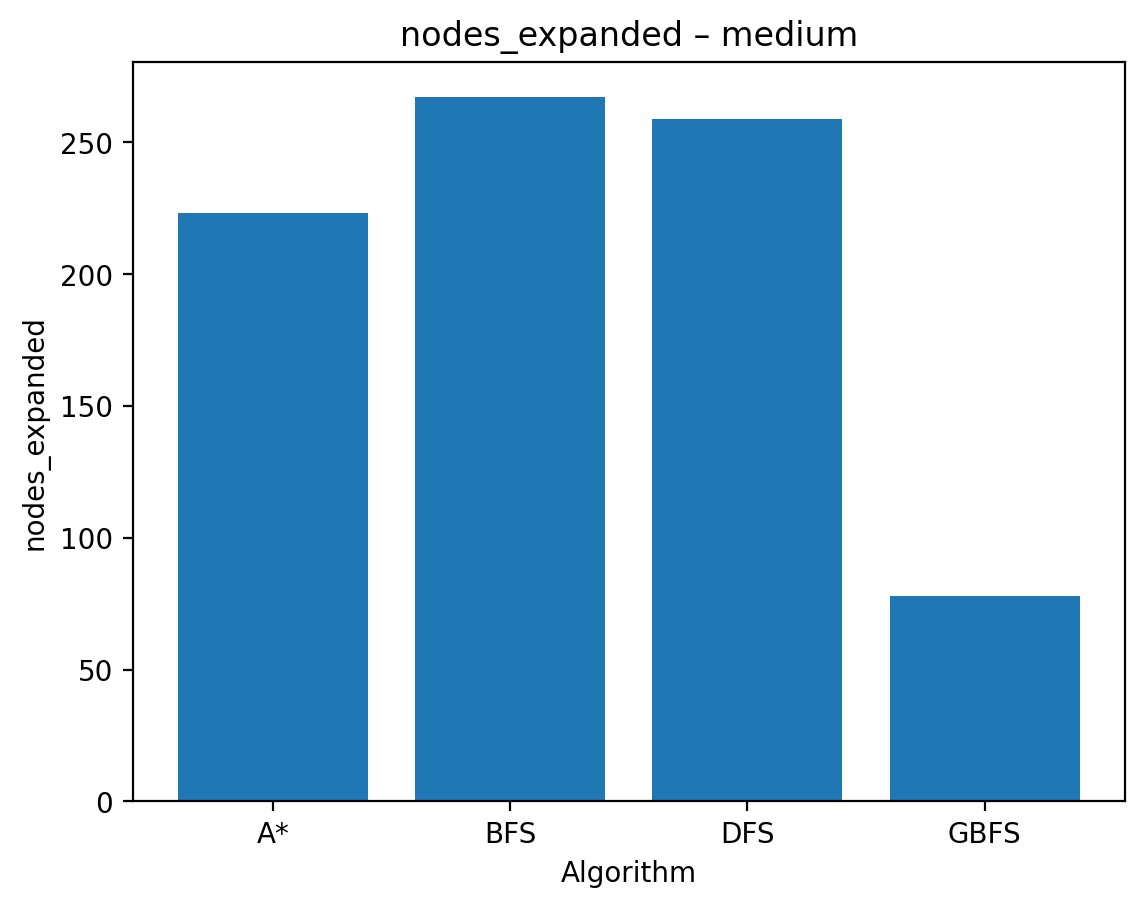

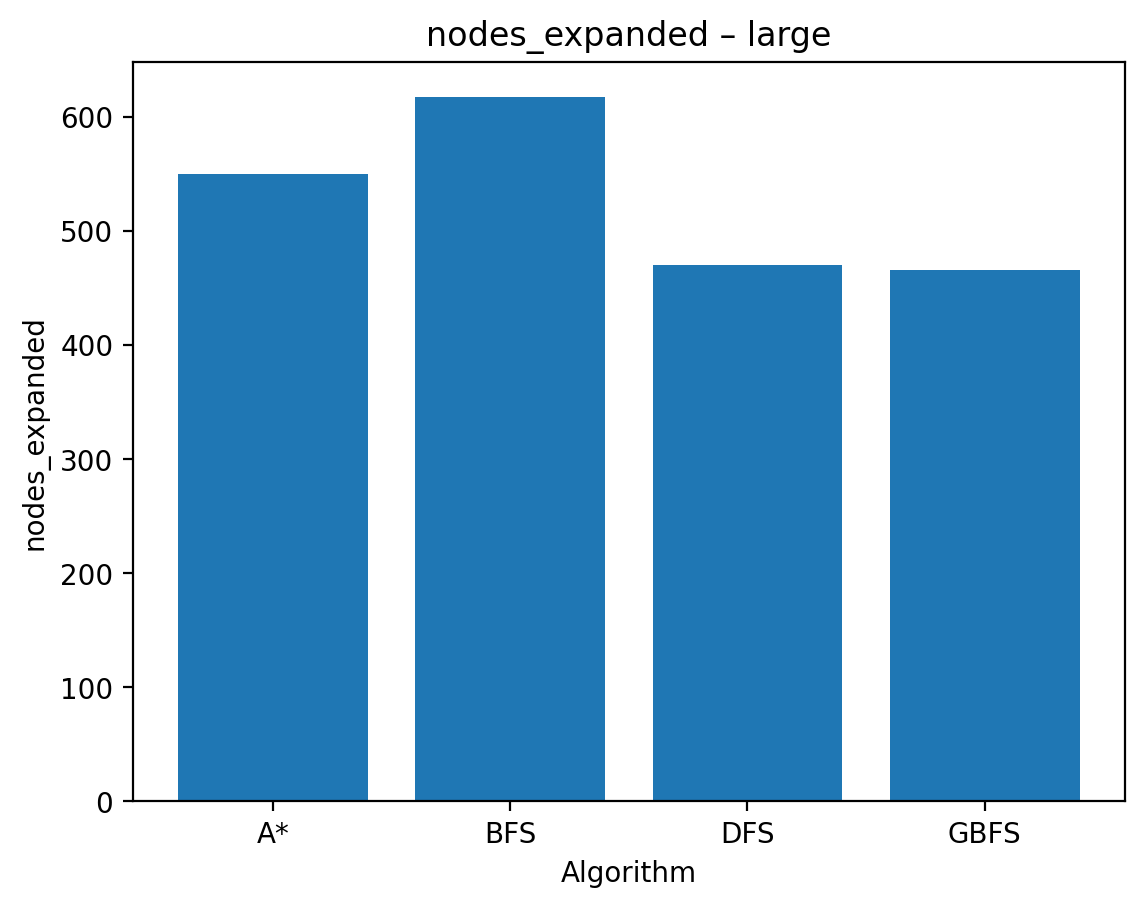

In [25]:
import matplotlib.pyplot as plt

def plot_metric(df, metric):
    for mz in df["maze"].unique():
        d = df[df["maze"]==mz].copy()
        d = d.sort_values("algo")
        plt.figure()
        plt.bar(d["algo"], d[metric])
        plt.title(f"{metric} – {mz}")
        plt.xlabel("Algorithm"); plt.ylabel(metric)
        plt.show()

plot_metric(df_all, "path_len")
plot_metric(df_all, "nodes_expanded")

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [26]:
# Add discussion
"""
- 4 thuật toán tìm kiếm đều tìm được đường đi trong mê cung
- BFS và A* đều tìm ra đương đi tối ưu nhất
- A* và GBFS có số note m rộng ít hơn do sử dụng heuristics
- DFS tiết kiệm bộ nhớ nhưng không đảm bảo tìm được đường đi tối ưu (dùng khi muốn tiết kiệm bộ nhớ)
"""

'\n- 4 thuật toán tìm kiếm đều tìm được đường đi trong mê cung\n- BFS và A* đều tìm ra đương đi tối ưu nhất\n- A* và GBFS có số note m rộng ít hơn do sử dụng heuristics\n- DFS tiết kiệm bộ nhớ nhưng không đảm bảo tìm được đường đi tối ưu (dùng khi muốn tiết kiệm bộ nhớ)\n'

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS 
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

In [27]:
def dfs_search(problem, depth_limit, animate=False, flag = False):
    s0 = problem.initial_state()
    maze_anim = []
    nodes_expanded = 0
    max_depth_seen = 0
    visited_counter = set()   # <— thêm dòng này

    def rec(node, on_path, flag = False ):
        nonlocal nodes_expanded, max_depth_seen
        nodes_expanded += 1
        
        max_depth_seen = max(max_depth_seen, node.depth)
        visited_counter.add(node.state)   # <— log state đã ghé

        if problem.goal_test(node.state):
            return node
        if node.depth == depth_limit:
            # print("Reached depth limit")
            return None
        for s2, a, _ in problem.successors(node.state):
            if s2 in on_path:    # cycle checking
                continue
            child = Node(s2, parent=node, action=a, depth=node.depth+1)
            on_path.add(s2)
            if animate:
                maze_anim.append(snapshot(problem.maze, path=child.path()))
            res = rec(child, on_path)
            if res is not None:
                return res
            on_path.remove(s2)   # backtrack
        return None

    root = Node(s0)
    sol = rec(root, on_path={s0})
    if sol is None:
        flag = False
        return {
            "path": None,
            "reached": visited_counter,     # <— luôn là set, không None
            "actions": [],
            "maze_anim": maze_anim,
            "metrics": {"algo":"DFS", "nodes_expanded": nodes_expanded, "max_depth_seen": max_depth_seen}
        }, flag
    p = sol.path()
    flag = True
    return {
        "path": p,
        "reached": visited_counter,         # <— luôn là set
        "actions": sol.actions(),
        "maze_anim": maze_anim + ([snapshot(problem.maze, path=p)] if animate else []),
        "metrics": {
            "algo": "DFS",
            "path_len": len(p)-1,
            "solution_depth": len(p)-1,
            "nodes_expanded": nodes_expanded,
            "max_depth_seen": max_depth_seen
        }
    }, flag
def IDF():
    flag = True
    for depth in range(1, 100000):
        print("Depth limit:", depth)
        lst, flag = dfs_search(problem, depth_limit=depth, animate=False, flag=False)
        if flag == True:
            print(lst)
            break
        else:
            print("Not found path")

In [28]:
IDF()
# DFS
# res_dfs = dfs_search(problem, animate=True)
# print(res_dfs["metrics"])
# # ani_dfs = mh.animate_maze(res_dfs, repeat=False)
# # HTML(ani_dfs.to_html5_video())
# ani_dfs = mh.animate_maze(res_dfs, repeat=False)
# from IPython.display import HTML
# HTML(ani_dfs.to_jshtml())

Depth limit: 1
Not found path
Depth limit: 2
Not found path
Depth limit: 3
Not found path
Depth limit: 4
Not found path
Depth limit: 5
Not found path
Depth limit: 6
Not found path
Depth limit: 7
Not found path
Depth limit: 8
Not found path
Depth limit: 9
Not found path
Depth limit: 10
Not found path
Depth limit: 11
Not found path
Depth limit: 12
Not found path
Depth limit: 13
Not found path
Depth limit: 14
Not found path
Depth limit: 15
Not found path
Depth limit: 16
Not found path
Depth limit: 17
Not found path
Depth limit: 18
Not found path
Depth limit: 19
{'path': [(np.int64(3), np.int64(11)), (np.int64(3), np.int64(12)), (np.int64(3), np.int64(13)), (np.int64(4), np.int64(13)), (np.int64(5), np.int64(13)), (np.int64(5), np.int64(12)), (np.int64(6), np.int64(12)), (np.int64(7), np.int64(12)), (np.int64(7), np.int64(11)), (np.int64(7), np.int64(10)), (np.int64(8), np.int64(10)), (np.int64(8), np.int64(9)), (np.int64(8), np.int64(8)), (np.int64(8), np.int64(7)), (np.int64(8), np.int64

### Multiple Goals 
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [29]:
def bfs_search(problem, animate=False):
    multi_path = []          # danh sách nghiệm cho từng goal
    multi_goal = set()       # tập goal đã tìm thấy
    s0 = problem.initial_state()

    if problem.goal_test(s0):
        multi_goal.add(s0)
        multi_path.append({
            "path": [s0],
            "reached": {s0},
            "actions": [],
            "maze_anim": []
        })

    frontier = deque([Node(s0)])
    reached  = {s0}
    maze_anim = [snapshot(problem.maze, reached=reached, frontier=[s0])] if animate else []

    nodes_expanded = 0
    max_frontier = 1

    while frontier:
        node = frontier.popleft()
        nodes_expanded += 1

        for s2, a, _ in problem.successors(node.state):
            if s2 in reached:
                continue

            child = Node(s2, parent=node, action=a, depth=node.depth+1)

            if problem.goal_test(s2) and s2 not in multi_goal:
                multi_goal.add(s2)
                p = child.path()
                res = {
                    "path": p,
                    "reached": reached | {s2},
                    "actions": child.actions(),
                    "maze_anim": maze_anim + ([snapshot(problem.maze, path=p)] if animate else []),
                    "metrics": {
                        "algo": "BFS",
                        "path_len": len(p)-1,
                        "solution_depth": child.depth,
                        "nodes_expanded": nodes_expanded,
                        "max_frontier": max(max_frontier, len(frontier)+1)
                    }
                }
                multi_path.append(res)

            reached.add(s2)
            frontier.append(child)

        max_frontier = max(max_frontier, len(frontier))
        if animate:
            maze_anim.append(snapshot(problem.maze, reached=reached, frontier=[n.state for n in frontier]))

    # 🚩 SỬA CHỖ NÀY: thay vì return cố định, trả về toàn bộ multi_path
    return {
        "solutions": multi_path,
        "reached": reached,
        "maze_anim": maze_anim,
        "metrics": {
            "algo": "BFS-multi",
            "num_goals_found": len(multi_path),
            "nodes_expanded": nodes_expanded,
            "max_frontier": max_frontier
        }
    }


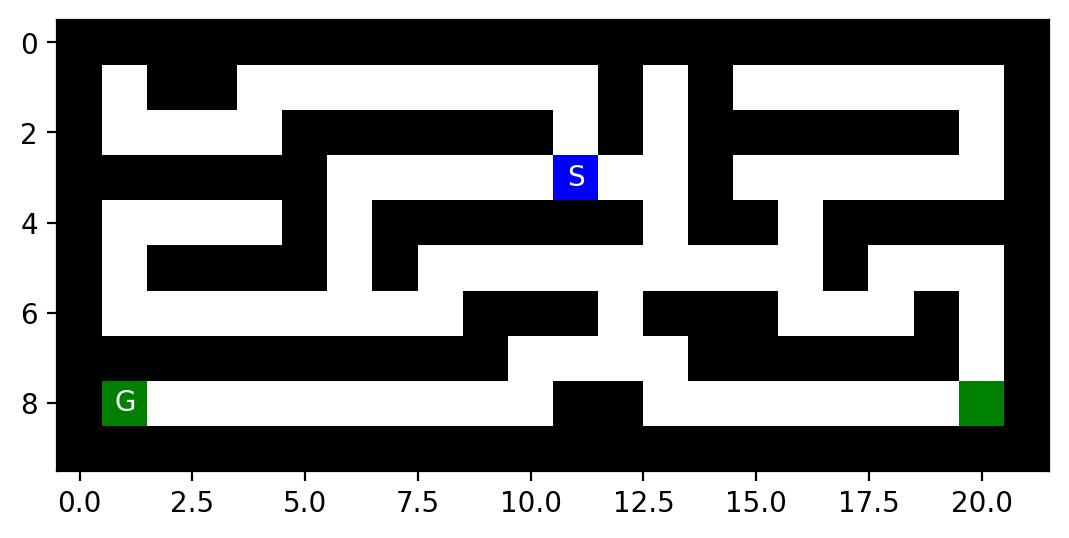

{'algo': 'BFS-multi', 'num_goals_found': 1, 'nodes_expanded': 94, 'max_frontier': 8}
Goal 1: path_len=19, depth=19
Path length: 19
Reached squares: 92
Action sequence: ['RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT']


In [34]:
# Load maze 
with open("small_maze1.txt","r") as f: 
    maze_str = f.read() 
maze = mh.parse_maze(maze_str) 
mh.show_maze(maze) 
problem = MazeProblem(maze)
res_bfs = bfs_search(problem, animate=True)
print(res_bfs["metrics"])

for i, sol in enumerate(res_bfs["solutions"], 1):
    print(f"Goal {i}: path_len={sol['metrics']['path_len']}, depth={sol['metrics']['solution_depth']}")
    ani_bfs = mh.animate_maze(sol, repeat=False)
    display(HTML(ani_bfs.to_jshtml()))


## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [31]:
# Your code/answer goes here

### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [32]:
# Your code/answer goes here

### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [33]:
# Your code/answer goes here